In [2]:
import numpy as np
import matplotlib.pyplot as plt
import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry

In [6]:
merged["risk_score"] = merged["Value"] * (merged["apparent_temperature_max"])
merged.groupby("ZCTA")["risk_score"].mean().sort_values(ascending=False).head(10)

ZCTA
3612207    61.020705
3614211    60.690301
3614303    60.635234
3612202    60.555692
3613202    60.482269
3612307    60.304830
3614204    60.280355
3614605    60.219169
3614212    60.188576
3613205    60.133509
Name: risk_score, dtype: float64

In [7]:
# Create risk_tier: bucket risk_score into five 20-point categories:\n
# 1 -> 0-19, 2 -> 20-39, 3 -> 40-59, 4 -> 60-79, 5 -> 80+
# Ensure we handle missing or out-of-range values
def score_to_tier(x):
    try:
        if pd.isna(x):
            return pd.NA
        # cap negative values to 0
        val = max(0, float(x))
        # integer division by 20, then +1, cap at 5
        tier = int(val) // 20 + 1
        return min(max(tier, 1), 5)
    except Exception:
        return pd.NA

merged["risk_tier"] = merged["risk_score"].apply(score_to_tier)
# Show counts per tier and top ZCTAs by mean risk_score
print('risk_tier value counts:')
print(merged["risk_tier"].value_counts(dropna=False).sort_index())

risk_tier value counts:
risk_tier
1    306662
2    198766
3     91034
4     35856
5      6718
Name: count, dtype: int64


<Axes: title={'center': 'Average risk_tier per ZCTA'}, ylabel='Frequency'>

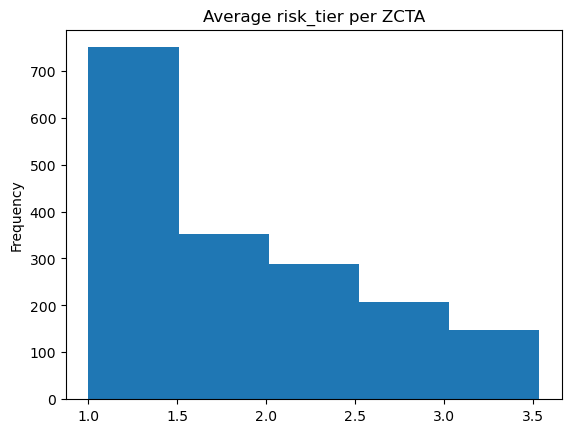

In [8]:
merged.groupby("ZCTA")["risk_tier"].mean().plot(kind='hist', bins=5, title='Average risk_tier per ZCTA')

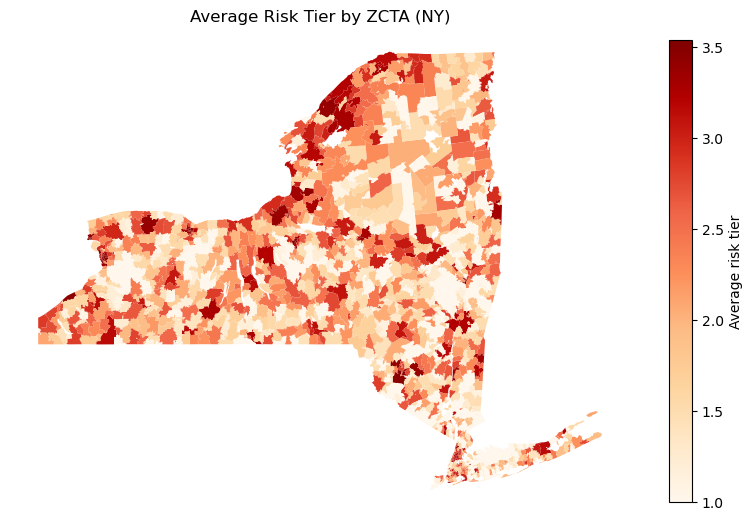

In [9]:
# Map average risk_tier by ZCTA using the provided shapefile
import geopandas as gpd
# compute mean tier per ZCTA (ZCTA in heat index appears to include state prefix; use last 5 chars)
avg_tier = merged.groupby('ZCTA')['risk_tier'].mean().reset_index(name='avg_risk_tier')
avg_tier['zip5'] = avg_tier['ZCTA'].astype(str).str[-5:].str.zfill(5)
# load ZCTA shapefile (tl_2020_us_zcta520)
zcta_gdf = gpd.read_file('tl_2020_us_zcta520/tl_2020_us_zcta520.shp')
# find a likely ZCTA field name in the shapefile and normalize to 5-digit strings
zcta_field = None
for c in zcta_gdf.columns:
    if 'ZCTA' in str(c).upper() or 'ZCTA5' in str(c).upper() or 'ZCT' in str(c).upper():
        zcta_field = c
        break
if zcta_field is None:
    # fallback: try common field names
    for cand in ['ZCTA5CE10','ZCTA5CE20','ZCTA5CE20']:
        if cand in zcta_gdf.columns:
            zcta_field = cand
            break
if zcta_field is None:
    raise KeyError('Could not find a ZCTA field in shapefile; available: ' + ','.join(zcta_gdf.columns))
zcta_gdf['zip5'] = zcta_gdf[zcta_field].astype(str).str.zfill(5)
# merge averaged tiers onto the geodataframe
map_gdf = zcta_gdf.merge(avg_tier[['zip5','avg_risk_tier']], on='zip5', how='left')
# restrict to ZCTAs that have data to zoom in (optional) -- comment out to show whole US
map_plot = map_gdf[map_gdf['avg_risk_tier'].notna()]
# plot
ax = map_plot.plot(column='avg_risk_tier', cmap='OrRd', legend=True, figsize=(10,10),
                   legend_kwds={'label': 'Average risk tier', 'shrink': 0.6},
                   missing_kwds={'color': 'lightgrey'})
ax.set_title('Average Risk Tier by ZCTA (NY)')
ax.set_axis_off()
# save figure
import matplotlib.pyplot as plt
plt.savefig('figures/nyc_avg_risk_tier_zcta.png', dpi=150, bbox_inches='tight')
plt.show()

/var/folders/pr/0jl9zy5j5nvcs0ycl3xdjjmm0000gn/T/ipykernel_36004/784974614.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zcta_gdf['centroid'] = zcta_gdf.geometry.centroid
/var/folders/pr/0jl9zy5j5nvcs0ycl3xdjjmm0000gn/T/ipykernel_36004/784974614.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zcta_gdf['lon'] = zcta_gdf.centroid.x
/var/folders/pr/0jl9zy5j5nvcs0ycl3xdjjmm0000gn/T/ipykernel_36004/784974614.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zcta_gdf['lat'] = zcta_gdf.centroid.y


nyc_avg_tier row count: 198


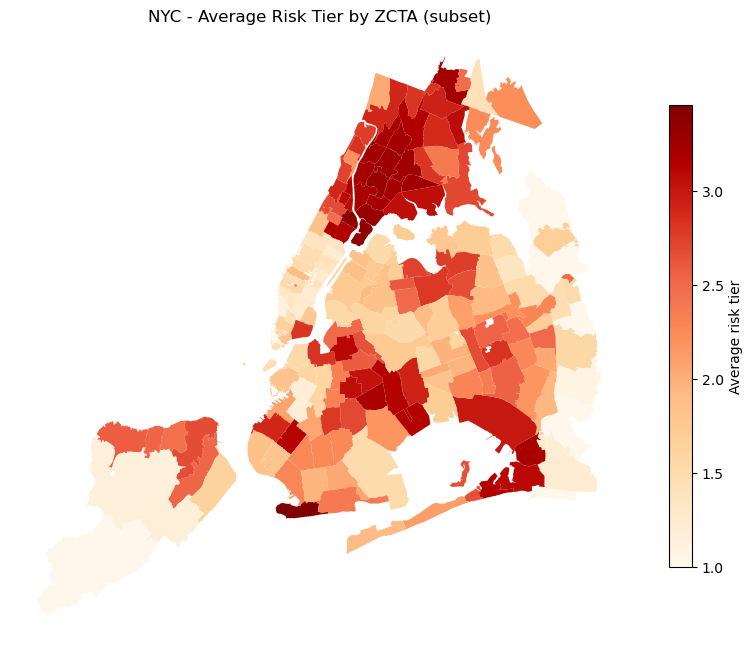

In [10]:
# NYC-only subset plotting (self-contained)
import geopandas as gpd
import pandas as pd
# ensure merged exists in notebook namespace; if not, load the CSV
try:
    merged
except NameError:
    merged = pd.read_csv('merged_daily_temp_heat_index.csv', parse_dates=['date'])
# compute average risk_tier per ZCTA and normalize zip5
avg_tier = merged.groupby('ZCTA')['risk_tier'].mean().reset_index(name='avg_risk_tier')
avg_tier['zip5'] = avg_tier['ZCTA'].astype(str).str[-5:].str.zfill(5)
# load ZCTA shapefile
zcta_gdf = gpd.read_file('tl_2020_us_zcta520/tl_2020_us_zcta520.shp')
# detect possible id field and create zip5 in shapefile
zcta_field = None
for c in zcta_gdf.columns:
    if 'ZCTA' in str(c).upper() or 'GEOID' in str(c).upper() or 'ZCT' in str(c).upper():
        zcta_field = c
        break
if zcta_field is None:
    raise KeyError('Could not find a ZCTA-like field in shapefile; available: ' + ','.join(zcta_gdf.columns))
zcta_gdf['zip5'] = zcta_gdf[zcta_field].astype(str).str.zfill(5)
# project to WGS84 and compute centroids for bbox selection
zcta_gdf = zcta_gdf.to_crs(epsg=4326)
zcta_gdf['centroid'] = zcta_gdf.geometry.centroid
zcta_gdf['lon'] = zcta_gdf.centroid.x
zcta_gdf['lat'] = zcta_gdf.centroid.y
# NYC bounding box (approx):
minx, miny, maxx, maxy = -74.25559, 40.49612, -73.70001, 40.91553
nyc_zctas = zcta_gdf[(zcta_gdf['lon'] >= minx) & (zcta_gdf['lon'] <= maxx) & (zcta_gdf['lat'] >= miny) & (zcta_gdf['lat'] <= maxy)].copy()
# build nyc_avg_tier subset from avg_tier
nyc_zip5s = set(nyc_zctas['zip5'].astype(str))
nyc_avg_tier = avg_tier[avg_tier['zip5'].isin(nyc_zip5s)].copy()
print('nyc_avg_tier row count:', len(nyc_avg_tier))
# merge subset back to geometry and plot
nyc_map = nyc_zctas.merge(nyc_avg_tier[['zip5','avg_risk_tier']], on='zip5', how='inner')
import matplotlib.pyplot as plt
if nyc_map.empty:
    print('No NYC zips matched the averaged tiers. Check zip formats (zip5) and CSV generation.')
else:
    ax = nyc_map.plot(column='avg_risk_tier', cmap='OrRd', legend=True, figsize=(10,10),
                      legend_kwds={'label': 'Average risk tier', 'shrink': 0.6})
    ax.set_title('NYC - Average Risk Tier by ZCTA (subset)')
    ax.set_axis_off()
    plt.savefig('figures/nyc_avg_risk_tier_zcta_subset.png', dpi=150, bbox_inches='tight')
    plt.show()


/var/folders/pr/0jl9zy5j5nvcs0ycl3xdjjmm0000gn/T/ipykernel_36004/1797612675.py:45: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zcta_gdf['centroid'] = zcta_gdf.geometry.centroid
/var/folders/pr/0jl9zy5j5nvcs0ycl3xdjjmm0000gn/T/ipykernel_36004/1797612675.py:46: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zcta_gdf['lon'] = zcta_gdf.centroid.x
/var/folders/pr/0jl9zy5j5nvcs0ycl3xdjjmm0000gn/T/ipykernel_36004/1797612675.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zcta_gdf['lat'] = zcta_gdf.centroid.y


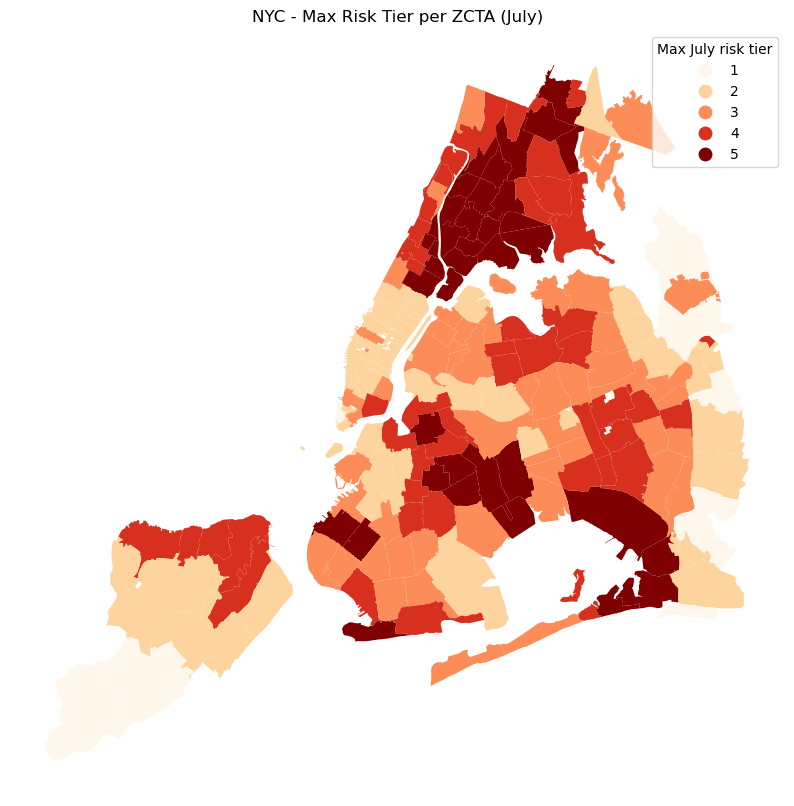

In [11]:
# Max July risk_tier per ZCTA (NYC)
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# load or use merged
try:
    merged
except NameError:
    merged = pd.read_csv('merged_daily_temp_heat_index.csv', parse_dates=['date'])

# ensure risk_tier exists
if 'risk_tier' not in merged.columns:
    def score_to_tier(x):
        try:
            if pd.isna(x):
                return pd.NA
            val = max(0, float(x))
            tier = int(val) // 20 + 1
            return min(max(tier,1),5)
        except Exception:
            return pd.NA
    merged['risk_score'] = merged['Value'] * merged['apparent_temperature_max']
    merged['risk_tier'] = merged['risk_score'].apply(score_to_tier)

# filter to July
merged['month'] = pd.DatetimeIndex(merged['date']).month
july = merged[merged['month'] == 7].copy()
# compute max tier per ZCTA
max_july = july.groupby('ZCTA')['risk_tier'].max().reset_index(name='max_risk_tier')
max_july['zip5'] = max_july['ZCTA'].astype(str).str[-5:].str.zfill(5)

# load shapefile and compute NYC bbox subset (re-using logic)
zcta_gdf = gpd.read_file('tl_2020_us_zcta520/tl_2020_us_zcta520.shp')
# detect id field
zcta_field = None
for c in zcta_gdf.columns:
    if 'ZCTA' in str(c).upper() or 'GEOID' in str(c).upper() or 'ZCT' in str(c).upper():
        zcta_field = c
        break
if zcta_field is None:
    raise KeyError('Could not find a ZCTA-like field in shapefile; available: ' + ','.join(zcta_gdf.columns))
zcta_gdf['zip5'] = zcta_gdf[zcta_field].astype(str).str.zfill(5)
zcta_gdf = zcta_gdf.to_crs(epsg=4326)
zcta_gdf['centroid'] = zcta_gdf.geometry.centroid
zcta_gdf['lon'] = zcta_gdf.centroid.x
zcta_gdf['lat'] = zcta_gdf.centroid.y
minx, miny, maxx, maxy = -74.25559, 40.49612, -73.70001, 40.91553
nyc_zctas = zcta_gdf[(zcta_gdf['lon'] >= minx) & (zcta_gdf['lon'] <= maxx) & (zcta_gdf['lat'] >= miny) & (zcta_gdf['lat'] <= maxy)].copy()
# merge max_july into nyc_zctas
nyc_max = nyc_zctas.merge(max_july[['zip5','max_risk_tier']], on='zip5', how='left')

# plot discrete categories 1..5 (use colors per tier)
if nyc_max['max_risk_tier'].notna().sum() == 0:
    print('No July max risk tiers found for NYC zctas - check data alignment')
else:
    # convert to categorical to get discrete legend
    nyc_max['tier_cat'] = nyc_max['max_risk_tier'].astype('Int64')
    cmap = plt.get_cmap('OrRd', 5)
    ax = nyc_max.plot(column='tier_cat', cmap=cmap, categorical=True, legend=True, figsize=(10,10),
                      legend_kwds={'title':'Max July risk tier'})
    ax.set_title('NYC - Max Risk Tier per ZCTA (July)')
    ax.set_axis_off()
    plt.savefig('figures/nyc_max_risk_tier_july_zcta.png', dpi=150, bbox_inches='tight')
    plt.show()


/var/folders/pr/0jl9zy5j5nvcs0ycl3xdjjmm0000gn/T/ipykernel_36004/2642758213.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zcta_gdf['centroid'] = zcta_gdf.geometry.centroid
/var/folders/pr/0jl9zy5j5nvcs0ycl3xdjjmm0000gn/T/ipykernel_36004/2642758213.py:32: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zcta_gdf['lon'] = zcta_gdf.centroid.x
/var/folders/pr/0jl9zy5j5nvcs0ycl3xdjjmm0000gn/T/ipykernel_36004/2642758213.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zcta_gdf['lat'] = zcta_gdf.centroid.y


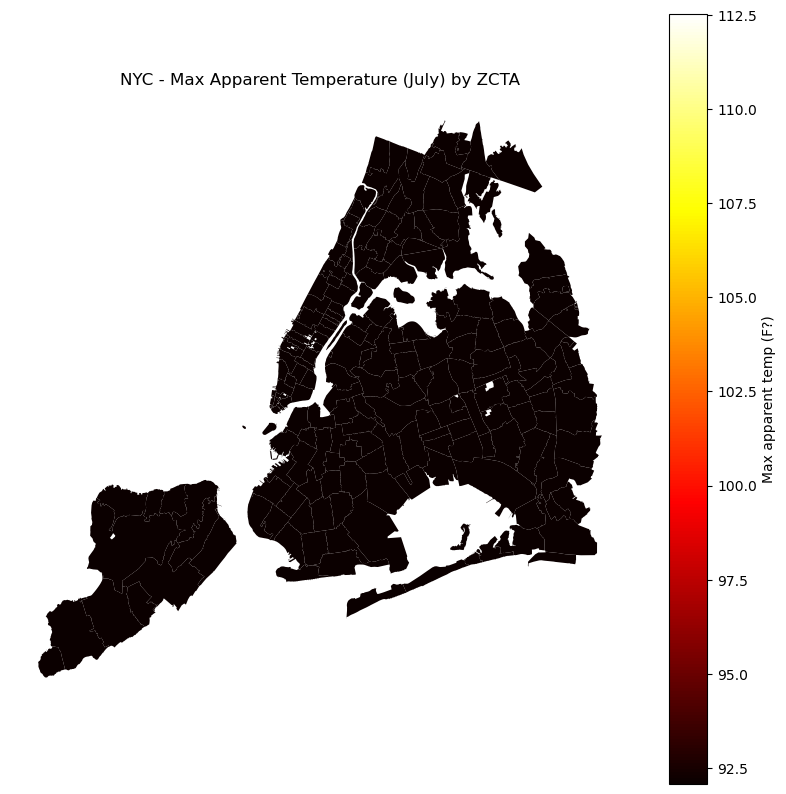

In [12]:
# Max apparent_temperature_max in July per ZCTA (NYC)
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# load merged if needed
try:
    merged
except NameError:
    merged = pd.read_csv('merged_daily_temp_heat_index.csv', parse_dates=['date'])

# filter to July
merged['month'] = pd.DatetimeIndex(merged['date']).month
july = merged[merged['month'] == 7].copy()
# compute max apparent_temperature_max per ZCTA
max_temp = july.groupby('ZCTA')['apparent_temperature_max'].max().reset_index(name='max_apparent_temp')
max_temp['zip5'] = max_temp['ZCTA'].astype(str).str[-5:].str.zfill(5)

# load shapefile and select NYC zctas by bbox
zcta_gdf = gpd.read_file('tl_2020_us_zcta520/tl_2020_us_zcta520.shp')
# detect id field
zcta_field = None
for c in zcta_gdf.columns:
    if 'ZCTA' in str(c).upper() or 'GEOID' in str(c).upper() or 'ZCT' in str(c).upper():
        zcta_field = c
        break
if zcta_field is None:
    raise KeyError('Could not find a ZCTA-like field in shapefile; available: ' + ','.join(zcta_gdf.columns))
zcta_gdf['zip5'] = zcta_gdf[zcta_field].astype(str).str.zfill(5)
zcta_gdf = zcta_gdf.to_crs(epsg=4326)
zcta_gdf['centroid'] = zcta_gdf.geometry.centroid
zcta_gdf['lon'] = zcta_gdf.centroid.x
zcta_gdf['lat'] = zcta_gdf.centroid.y
minx, miny, maxx, maxy = -74.25559, 40.49612, -73.70001, 40.91553
nyc_zctas = zcta_gdf[(zcta_gdf['lon'] >= minx) & (zcta_gdf['lon'] <= maxx) & (zcta_gdf['lat'] >= miny) & (zcta_gdf['lat'] <= maxy)].copy()

# merge and plot
nyc_temp = nyc_zctas.merge(max_temp[['zip5','max_apparent_temp']], on='zip5', how='left')
if nyc_temp['max_apparent_temp'].notna().sum() == 0:
    print('No July apparent temp values found for NYC zctas - check data alignment')
else:
    ax = nyc_temp.plot(column='max_apparent_temp', cmap='hot', legend=True, figsize=(10,10),
                       legend_kwds={'label':'Max apparent temp (F?)'})
    ax.set_title('NYC - Max Apparent Temperature (July) by ZCTA')
    ax.set_axis_off()
    plt.savefig('figures/nyc_max_apparent_temp_july_zcta.png', dpi=150, bbox_inches='tight')
    plt.show()
